In [1]:
# Code aus "Neuronale Netze selbst programmieren,
# ein verständlicher Einstieg mit Python"
# von Tariq Rashid , O'Reilly
# license GPLv2

import numpy
# scipy.special for the sigmoid function expit()
import scipy.special
import matplotlib.pyplot 
%matplotlib inline
import os
# helper to load data from PNG image files
import imageio
# glob helps select multiple files using patterns
import glob
# Importing cv2 // !pip install opencv-python
import cv2
# import random to shuffle array for training
import random

In [2]:
# neural network class definition
class neuralNetwork:

    # initialise the neural network
    def __init__(self, nodesLayerInput, nodesLayerHidden1, nodesLayerHidden2, nodesLayerHidden3, nodesLayerOutput, learningrate):
        # set number of nodes in each layer
        self.inodes = nodesLayerInput
        self.h1nodes = nodesLayerHidden1
        self.h2nodes = nodesLayerHidden2
        self.h3nodes = nodesLayerHidden3
        self.onodes = nodesLayerOutput

        # learning rate
        self.lr = learningrate

        # link weight matrices
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        ##self.wih1 = numpy.random.normal(0.0, pow(self.h1nodes, -0.5), (self.h1nodes, self.inodes))
        ##self.wh1h2 = numpy.random.normal(0.0, pow(self.h2nodes, -0.5), (self.h2nodes, self.h1nodes))
        ##self.wh2h3 = numpy.random.normal(0.0, pow(self.h3nodes, -0.5), (self.h3nodes, self.h2nodes))
        ##self.wh3o = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.h3nodes))
        
        self.wih1 = (numpy.random.rand(self.h1nodes, self.inodes) - 0.5)
        self.wh1h2 = (numpy.random.rand(self.h2nodes, self.h1nodes) - 0.5)
        self.wh2h3 = (numpy.random.rand(self.h3nodes, self.h2nodes) - 0.5)
        self.wh3o = (numpy.random.rand(self.onodes, self.h3nodes) - 0.5)

        print("train wh3o: ",self.wh3o[0][0:3].flatten())

        # acitivation function is the sigmoid funciton
        self.activation_function = lambda x: scipy.special.expit(x)
    
        pass
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden1_inputs = numpy.dot(self.wih1, inputs)
        # calculate the signals emerging from hidden layer
        hidden1_outputs = self.activation_function(hidden1_inputs)
                
        # calculate signals into hidden layer
        hidden2_inputs = numpy.dot(self.wh1h2, hidden1_outputs)
        # calculate the signals emerging from hidden layer
        hidden2_outputs = self.activation_function(hidden2_inputs)
                
        # calculate signals into hidden layer
        hidden3_inputs = numpy.dot(self.wh2h3, hidden2_outputs)
        # calculate the signals emerging from hidden layer
        hidden3_outputs = self.activation_function(hidden3_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.wh3o, hidden3_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden3_errors = numpy.dot(self.wh3o.T, output_errors)
        hidden2_errors = numpy.dot(self.wh2h3.T, hidden3_errors)
        hidden1_errors = numpy.dot(self.wh1h2.T, hidden2_errors)
        
        # update the weights for the links between the hidden and output layers
        self.wh3o += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden3_outputs))
         # update the weights for the links between the hidden and output layers
        self.wh2h3 += self.lr * numpy.dot((hidden3_errors * hidden3_outputs * (1.0 - hidden3_outputs)), numpy.transpose(hidden2_outputs))
         # update the weights for the links between the hidden and output layers
        self.wh1h2 += self.lr * numpy.dot((hidden2_errors * hidden2_outputs * (1.0 - hidden2_outputs)), numpy.transpose(hidden1_outputs))
        # update the weights for the links between the input and hidden layers
        self.wih1 += self.lr * numpy.dot((hidden1_errors * hidden1_outputs * (1.0 - hidden1_outputs)), numpy.transpose(inputs))
        ##print("train wh3o: ",self.wh3o[0][0:3].flatten())

        print("train wh3o: ",final_outputs[0:3].flatten())

        pass

    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden1_inputs = numpy.dot(self.wih1, inputs)
        # calculate the signals emerging from hidden layer
        hidden1_outputs = self.activation_function(hidden1_inputs)
                
        # calculate signals into hidden layer
        hidden2_inputs = numpy.dot(self.wh1h2, hidden1_outputs)
        # calculate the signals emerging from hidden layer
        hidden2_outputs = self.activation_function(hidden2_inputs)
                
        # calculate signals into hidden layer
        hidden3_inputs = numpy.dot(self.wh2h3, hidden2_outputs)
        # calculate the signals emerging from hidden layer
        hidden3_outputs = self.activation_function(hidden3_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.wh3o, hidden3_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        print("query hidden_output: ",hidden1_outputs[0:3].flatten())
        return final_outputs

    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden3_outputs = numpy.dot(self.wh3o.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden3_outputs -= numpy.min(hidden3_outputs)
        hidden3_outputs /= numpy.max(hidden3_outputs)
        hidden3_outputs *= 0.98
        hidden3_outputs += 0.01
        
        # calculate the signal into the final output layer
        hidden3_inputs = self.inverse_activation_function(hidden3_outputs)

        # calculate the signal out of the hidden layer
        hidden2_outputs = numpy.dot(self.wh2h3.T, hidden3_inputs)
        # scale them back to 0.01 to .99
        hidden2_outputs -= numpy.min(hidden2_outputs)
        hidden2_outputs /= numpy.max(hidden2_outputs)
        hidden2_outputs *= 0.98
        hidden2_outputs += 0.01
        
        # calculate the signal into the final output layer
        hidden2_inputs = self.inverse_activation_function(hidden2_outputs)

        # calculate the signal out of the hidden layer
        hidden1_outputs = numpy.dot(self.who.T, hidden2_inputs)
        # scale them back to 0.01 to .99
        hidden1_outputs -= numpy.min(hidden1_outputs)
        hidden1_outputs /= numpy.max(hidden1_outputs)
        hidden1_outputs *= 0.98
        hidden1_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden1_inputs = self.inverse_activation_function(hidden1_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden1_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [3]:
# neural network class definition
class neuralNetwork:

    # initialise the neural network
    def __init__(self, nodesLayerInput, nodesLayerHidden1, nodesLayerHidden2, nodesLayerHidden3, nodesLayerOutput, learningrate):
        # set number of nodes in each layer
        self.inodes = nodesLayerInput
        self.h1nodes = nodesLayerHidden1
        self.h2nodes = nodesLayerHidden2
        self.h3nodes = nodesLayerHidden3
        self.onodes = nodesLayerOutput

        # learning rate
        self.lr = learningrate

        # link weight matrices
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        ##self.wih1 = numpy.random.normal(0.0, pow(self.h1nodes, -0.5), (self.h1nodes, self.inodes))
        ##self.wh1h2 = numpy.random.normal(0.0, pow(self.h2nodes, -0.5), (self.h2nodes, self.h1nodes))
        ##self.wh2h3 = numpy.random.normal(0.0, pow(self.h3nodes, -0.5), (self.h3nodes, self.h2nodes))
        ##self.wh3o = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.h3nodes))
        
        self.wih1 = (numpy.random.rand(self.h1nodes, self.inodes) - 0.5)
        self.wh1h2 = (numpy.random.rand(self.h2nodes, self.h1nodes) - 0.5)
        self.wh2h3 = (numpy.random.rand(self.h3nodes, self.h2nodes) - 0.5)
        self.wh3o = (numpy.random.rand(self.onodes, self.h3nodes) - 0.5)

        print("train wh3o: ",self.wh3o[0][0:3].flatten())

        # acitivation function is the sigmoid funciton
        self.activation_function = lambda x: scipy.special.expit(x)
    
        pass
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden1_inputs = numpy.dot(self.wih1, inputs)
        # calculate the signals emerging from hidden layer
        hidden1_outputs = self.activation_function(hidden1_inputs)
                
        # calculate signals into hidden layer
        hidden2_inputs = numpy.dot(self.wh1h2, hidden1_outputs)
        # calculate the signals emerging from hidden layer
        hidden2_outputs = self.activation_function(hidden2_inputs)
                
        # calculate signals into hidden layer
        hidden3_inputs = numpy.dot(self.wh2h3, hidden2_outputs)
        # calculate the signals emerging from hidden layer
        hidden3_outputs = self.activation_function(hidden3_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.wh3o, hidden3_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden3_errors = numpy.dot(self.wh3o.T, output_errors)
        hidden2_errors = numpy.dot(self.wh2h3.T, hidden3_errors)
        hidden1_errors = numpy.dot(self.wh1h2.T, hidden2_errors)
        
        # update the weights for the links between the hidden and output layers
        self.wh3o += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden3_outputs))
         # update the weights for the links between the hidden and output layers
        self.wh2h3 += self.lr * numpy.dot((hidden3_errors * hidden3_outputs * (1.0 - hidden3_outputs)), numpy.transpose(hidden2_outputs))
         # update the weights for the links between the hidden and output layers
        self.wh1h2 += self.lr * numpy.dot((hidden2_errors * hidden2_outputs * (1.0 - hidden2_outputs)), numpy.transpose(hidden1_outputs))
        # update the weights for the links between the input and hidden layers
        self.wih1 += self.lr * numpy.dot((hidden1_errors * hidden1_outputs * (1.0 - hidden1_outputs)), numpy.transpose(inputs))
        ##print("train wh3o: ",self.wh3o[0][0:3].flatten())

        print("train wh3o: ",final_outputs[0:3].flatten())

        pass

    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden1_inputs = numpy.dot(self.wih1, inputs)
        # calculate the signals emerging from hidden layer
        hidden1_outputs = self.activation_function(hidden1_inputs)
                
        # calculate signals into hidden layer
        hidden2_inputs = numpy.dot(self.wh1h2, hidden1_outputs)
        # calculate the signals emerging from hidden layer
        hidden2_outputs = self.activation_function(hidden2_inputs)
                
        # calculate signals into hidden layer
        hidden3_inputs = numpy.dot(self.wh2h3, hidden2_outputs)
        # calculate the signals emerging from hidden layer
        hidden3_outputs = self.activation_function(hidden3_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.wh3o, hidden3_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        print("query hidden_output: ",hidden1_outputs[0:3].flatten())
        return final_outputs

    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
# neural network class definition
class neuralNetwork:

    # initialise the neural network
    def __init__(self, nodesLayerInput, nodesLayerHidden1, nodesLayerHidden2, nodesLayerHidden3, nodesLayerOutput, learningrate):
        # set number of nodes in each layer
        self.inodes = nodesLayerInput
        self.h1nodes = nodesLayerHidden1
        self.h2nodes = nodesLayerHidden2
        self.h3nodes = nodesLayerHidden3
        self.onodes = nodesLayerOutput

        # learning rate
        self.lr = learningrate

        # link weight matrices
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        ##self.wih1 = numpy.random.normal(0.0, pow(self.h1nodes, -0.5), (self.h1nodes, self.inodes))
        ##self.wh1h2 = numpy.random.normal(0.0, pow(self.h2nodes, -0.5), (self.h2nodes, self.h1nodes))
        ##self.wh2h3 = numpy.random.normal(0.0, pow(self.h3nodes, -0.5), (self.h3nodes, self.h2nodes))
        ##self.wh3o = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.h3nodes))
        
        self.wih1 = (numpy.random.rand(self.h1nodes, self.inodes) - 0.5)
        self.wh1h2 = (numpy.random.rand(self.h2nodes, self.h1nodes) - 0.5)
        self.wh2h3 = (numpy.random.rand(self.h3nodes, self.h2nodes) - 0.5)
        self.wh3o = (numpy.random.rand(self.onodes, self.h3nodes) - 0.5)

        print("train wh3o: ",self.wh3o[0][0:3].flatten())

        # acitivation function is the sigmoid funciton
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)

        pass
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden1_inputs = numpy.dot(self.wih1, inputs)
        # calculate the signals emerging from hidden layer
        hidden1_outputs = self.activation_function(hidden1_inputs)
                
        # calculate signals into hidden layer
        hidden2_inputs = numpy.dot(self.wh1h2, hidden1_outputs)
        # calculate the signals emerging from hidden layer
        hidden2_outputs = self.activation_function(hidden2_inputs)
                
        # calculate signals into hidden layer
        hidden3_inputs = numpy.dot(self.wh2h3, hidden2_outputs)
        # calculate the signals emerging from hidden layer
        hidden3_outputs = self.activation_function(hidden3_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.wh3o, hidden3_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden3_errors = numpy.dot(self.wh3o.T, output_errors)
        hidden2_errors = numpy.dot(self.wh2h3.T, hidden3_errors)
        hidden1_errors = numpy.dot(self.wh1h2.T, hidden2_errors)
        
        # update the weights for the links between the hidden and output layers
        self.wh3o += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden3_outputs))
         # update the weights for the links between the hidden and output layers
        self.wh2h3 += self.lr * numpy.dot((hidden3_errors * hidden3_outputs * (1.0 - hidden3_outputs)), numpy.transpose(hidden2_outputs))
         # update the weights for the links between the hidden and output layers
        self.wh1h2 += self.lr * numpy.dot((hidden2_errors * hidden2_outputs * (1.0 - hidden2_outputs)), numpy.transpose(hidden1_outputs))
        # update the weights for the links between the input and hidden layers
        self.wih1 += self.lr * numpy.dot((hidden1_errors * hidden1_outputs * (1.0 - hidden1_outputs)), numpy.transpose(inputs))
        ##print("train wh3o: ",self.wh3o[0][0:3].flatten())

        print("train wh3o: ",final_outputs[0:3].flatten())

        pass

    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden1_inputs = numpy.dot(self.wih1, inputs)
        # calculate the signals emerging from hidden layer
        hidden1_outputs = self.activation_function(hidden1_inputs)
                
        # calculate signals into hidden layer
        hidden2_inputs = numpy.dot(self.wh1h2, hidden1_outputs)
        # calculate the signals emerging from hidden layer
        hidden2_outputs = self.activation_function(hidden2_inputs)
                
        # calculate signals into hidden layer
        hidden3_inputs = numpy.dot(self.wh2h3, hidden2_outputs)
        # calculate the signals emerging from hidden layer
        hidden3_outputs = self.activation_function(hidden3_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.wh3o, hidden3_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        print("query hidden_output: ",hidden1_outputs[0:3].flatten())
        return final_outputs

    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden3_outputs = numpy.dot(self.wh3o.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden3_outputs -= numpy.min(hidden3_outputs)
        hidden3_outputs /= numpy.max(hidden3_outputs)
        hidden3_outputs *= 0.98
        hidden3_outputs += 0.01

        # calculate the signal into the final output layer
        hidden3_inputs = self.inverse_activation_function(hidden3_outputs)

        # calculate the signal out of the hidden layer
        hidden2_outputs = numpy.dot(self.wh2h3.T, hidden3_inputs)
        # scale them back to 0.01 to .99
        hidden2_outputs -= numpy.min(hidden2_outputs)
        hidden2_outputs /= numpy.max(hidden2_outputs)
        hidden2_outputs *= 0.98
        hidden2_outputs += 0.01

        # calculate the signal into the final output layer
        hidden2_inputs = self.inverse_activation_function(hidden2_outputs)

        # calculate the signal out of the hidden layer
        hidden1_outputs = numpy.dot(self.wh1h2.T, hidden2_inputs)
        # scale them back to 0.01 to .99
        hidden1_outputs -= numpy.min(hidden1_outputs)
        hidden1_outputs /= numpy.max(hidden1_outputs)
        hidden1_outputs *= 0.98
        hidden1_outputs += 0.01

        # calculate the signal into the hidden layer
        hidden1_inputs = self.inverse_activation_function(hidden1_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih1.T, hidden1_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [4]:
# number of input, hidden and output nodes
imageAxis = 150
input_nodes = imageAxis**2
hidden1_nodes = 4000
hidden2_nodes = 300
hidden3_nodes = 25
output_nodes = 3

# learning rate
learning_rate = 0.2

# create instance of neural network
n = neuralNetwork(input_nodes, hidden1_nodes, hidden2_nodes, hidden3_nodes, output_nodes, learning_rate)

train wh3o:  [-0.20021158 -0.46231257 -0.09874363]


In [5]:
# https://stackoverflow.com/questions/7165749/open-file-in-a-relative-location-in-python
# relative path to files
fileDir = os.path.dirname(os.path.realpath('__file__'))
# For accessing the file in the parent folder of the current folder
# small test data for quick calculations
training_data_path = os.path.join(fileDir, '../../trainingdata/testdata/train_small/*.jpg') 
test_data_path = os.path.join(fileDir, '../../trainingdata/testdata/test_small/*.jpg') 
# real test data (60'000 training data / 10'000 test data)


In [6]:
# load training data in a list
training_data_list = []

# load all images from the folder
for image_file_name in glob.glob(training_data_path):
    
    # get image from path
    originalImage = cv2.imread(image_file_name)
    # resize the image with openCv2
    resizedImage = cv2.resize(originalImage, (imageAxis, imageAxis), interpolation=cv2.INTER_NEAREST)
    # gray the image
    resizedGrayImage = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)
    
    # use the filename to set the correct label
    if image_file_name.__contains__('cat.'):
        labelCatOrDog = 0
    else:
        labelCatOrDog = 1
    
    # load image data into an array
    print ("loading ... ", image_file_name)
    img_array = resizedGrayImage.flatten()
    
    # reshape from resized to input_nodes value, invert values
    img_data  = 255.0 - img_array.reshape(input_nodes)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    
    # append label and image data training data set
    record = numpy.append(labelCatOrDog,img_data)
    training_data_list.append(record)
    pass

loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.0.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.1.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.10.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.11.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.12.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.13.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.14.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.15.jpg
lo

loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.96.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.97.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.98.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\cat.99.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\dog.0.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\dog.1.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\dog.10.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/train_small\dog.11.jpg
lo

In [7]:
# train the neural network
# epochs is the number of times the training data set is used for training
epochs = 1

for e in range(epochs):
    # shuffel the training_data_list so we do not go: cat cat cat ... dog dog dog
    random.shuffle(training_data_list)
    
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        # 
        inputs = record[1:]
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(record[0])] = 0.99
        n.train(inputs, targets)
        ##print("trained a picture ", targets, inputs[0:3])
        pass
    pass

train wh3o:  [0.39152886 0.19915035 0.5099528 ]
train wh3o:  [0.28102402 0.83768873 0.181594  ]
train wh3o:  [0.61637531 0.58715833 0.08149504]
train wh3o:  [0.73743042 0.29466313 0.08303717]
train wh3o:  [0.79091303 0.1380607  0.08402428]
train wh3o:  [0.8362098  0.11856648 0.09119771]
train wh3o:  [0.85941469 0.11484795 0.08137395]
train wh3o:  [0.7633497  0.23150029 0.05062425]
train wh3o:  [0.67119177 0.39014241 0.04832403]
train wh3o:  [0.51201617 0.52559679 0.04760909]
train wh3o:  [0.63814945 0.40615965 0.04455727]
train wh3o:  [0.51147573 0.51348126 0.0438276 ]
train wh3o:  [0.42502633 0.59159162 0.04430375]
train wh3o:  [0.51210612 0.49993099 0.04374173]
train wh3o:  [0.4007733  0.57980511 0.04197111]
train wh3o:  [0.33240994 0.6652895  0.04356022]
train wh3o:  [0.29360666 0.71896374 0.04436381]
train wh3o:  [0.25472063 0.77069113 0.04780776]
train wh3o:  [0.33040141 0.66812794 0.04155452]
train wh3o:  [0.41605664 0.53342829 0.03633302]
train wh3o:  [0.50702328 0.44111298 0.03

train wh3o:  [0.29675864 0.70293697 0.0290071 ]
train wh3o:  [0.26908115 0.73040579 0.02867482]
train wh3o:  [0.24663547 0.75272768 0.02835262]
train wh3o:  [0.31022004 0.68976497 0.02906999]
train wh3o:  [0.38423559 0.61662082 0.02954292]
train wh3o:  [0.46200762 0.53982929 0.02974767]
train wh3o:  [0.53481856 0.46777246 0.02978739]
train wh3o:  [0.59689355 0.40598261 0.02961459]
train wh3o:  [0.51927411 0.48266538 0.0299758 ]
train wh3o:  [0.44884678 0.55152782 0.02994074]
train wh3o:  [0.38996526 0.60899299 0.02976052]
train wh3o:  [0.46802065 0.53318113 0.02993705]
train wh3o:  [0.40555306 0.59376332 0.02977976]
train wh3o:  [0.48308798 0.51852599 0.02991862]
train wh3o:  [0.5530746  0.44962826 0.02984149]
train wh3o:  [0.47893308 0.52233193 0.02989043]
train wh3o:  [0.41447047 0.58456212 0.0297542 ]
train wh3o:  [0.49128452 0.50968473 0.02982038]
train wh3o:  [0.55684798 0.43791722 0.02911658]
train wh3o:  [0.61470109 0.3810469  0.02886562]
train wh3o:  [0.65684357 0.33190441 0.02

In [8]:
# load test data in a list
test_data_list = []

# load all images from the folder
for image_file_name in glob.glob(test_data_path):
    
    # get image from path
    originalImage = cv2.imread(image_file_name)
    # resize the image with openCv2
    resizedImage = cv2.resize(originalImage, (imageAxis, imageAxis), interpolation=cv2.INTER_NEAREST)
    # gray the image
    resizedGrayImage = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)
    
    # use the filename to set the correct label
    if image_file_name.__contains__('cat.'):
        labelCatOrDog = 0
    else:
        labelCatOrDog = 1
    
    # load image data into an array
    print ("loading ... ", image_file_name)
    img_array = resizedGrayImage.flatten()
    
    # reshape from resized to input_nodes value, invert values
    img_data  = 255.0 - img_array.reshape(input_nodes)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    
    # append label and image data training data set
    record = numpy.append(labelCatOrDog,img_data)
    test_data_list.append(record)
    
    pass

loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12490.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12491.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12492.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12493.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12494.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12495.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_small\cat.12496.jpg
loading ...  C:\Users\schmi\Documents\CatDog-Python\CatDog-Python\Project\../../trainingdata/testdata/test_smal

In [9]:
# test the neural network
# scorecard for how well the network performs
scorecard = []

# go through all the records in the test data set
for record in test_data_list:
    # correct answer is first value
    correct_label = int(record[0])
    inputs = record[1:]
    # query the network
    outputs = n.query(inputs)
    ## print ("score outputs: ",outputs.flatten())

    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass
print(scorecard)

query hidden_output:  [1.00000000e+00 2.16584783e-55 1.78972548e-71]
query hidden_output:  [1.00000000e+00 2.32838058e-64 1.89986102e-84]
query hidden_output:  [1.0000000e+00 8.0866342e-77 1.0440585e-78]
query hidden_output:  [1.00000000e+000 8.70408231e-083 2.80293924e-110]
query hidden_output:  [1.00000000e+00 1.69925322e-67 4.33104310e-73]
query hidden_output:  [1.00000000e+00 7.16251471e-57 1.32507106e-73]
query hidden_output:  [1.00000000e+00 1.02732449e-45 4.63858186e-48]
query hidden_output:  [1.00000000e+00 8.46817019e-70 2.71138455e-84]
query hidden_output:  [1.00000000e+00 8.97881160e-69 4.81751466e-83]
query hidden_output:  [1.00000000e+00 5.47623277e-64 7.96444998e-87]
query hidden_output:  [1.00000000e+00 2.05752108e-51 1.33013703e-59]
query hidden_output:  [1.00000000e+000 1.42799972e-101 4.93780985e-131]
query hidden_output:  [1.00000000e+00 2.11111616e-80 7.34927152e-99]
query hidden_output:  [1.00000000e+00 3.46301847e-68 1.18196050e-71]
query hidden_output:  [1.000000

In [10]:
# calculate the performance score (correct answers/ all answers)
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.45454545454545453


query hidden_output:  [1.00000000e+00 2.32838058e-64 1.89986102e-84]
[0.66112436 0.33835106 0.02902318]
network says  0
match!


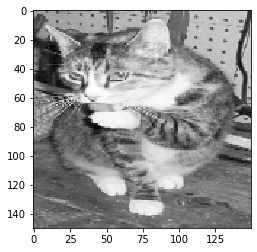

In [11]:
# test the neural network with the test image but only one and show the image

# record to test
item = 1

# plot image
matplotlib.pyplot.imshow(test_data_list[item][1:].reshape(imageAxis,imageAxis), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = test_data_list[item][0]
# data is remaining values
inputs = test_data_list[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs.flatten())

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass

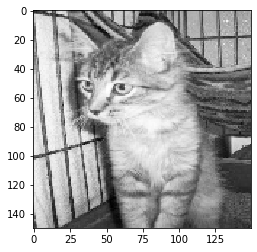

In [12]:
# plot image
matplotlib.pyplot.imshow(training_data_list[5][1:].reshape(imageAxis,imageAxis), cmap='Greys', interpolation='None')


[0.01 0.99 0.01]


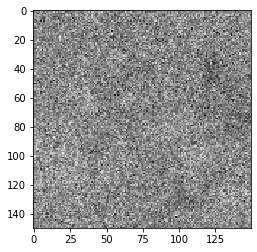

In [15]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 1
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(imageAxis,imageAxis), cmap='Greys', interpolation='None')